In [17]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

#We are finding out which vendor has the cheapest item say if Vendor A sells milk for 3 dollars but Vendor B sells milk for 2 dollars the milk will be considered by Vendor B
#All Vendors cheapest items are chosen before averaging which Vendor sells the chepeast product on average 
#The Histogram is the cheapest price amongest the vendors

print(plt)

<module 'matplotlib.pyplot' from 'C:\\Users\\Nah\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>


In [18]:
df = pd.read_csv("../data/cleaned_merged_data.csv")
nunique_vendors = df['vendor'].nunique()
unique_vendors = df['vendor'].unique()
print(f"Number of unique vendors: {nunique_vendors}")
print(f"List of unique vendors: {unique_vendors}")

C:\Users\Nah\AppData\Local\Temp\ipykernel_14724\1643259885.py:1: DtypeWarning: Columns (4,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/cleaned_merged_data.csv")


Number of unique vendors: 8
List of unique vendors: ['Voila' 'Galleria' 'Loblaws' 'Metro' 'NoFrills' 'SaveOnFoods' 'TandT'
 'Walmart']


In [19]:
df['nowtime'] = pd.to_datetime(df['nowtime'])

# Find the latest current price
latest_prices = df.loc[df.groupby(['product_name', 'vendor'])['nowtime'].idxmax()].reset_index(drop=True)

print("Inspecting latest_prices DataFrame:")
print(latest_prices.info())
print(latest_prices.head())

latest_prices['current_price'] = pd.to_numeric(latest_prices['current_price'], errors='coerce')

print("Checking for missing values in latest_prices:")
print(latest_prices.isnull().sum())

latest_prices = latest_prices.dropna(subset=['vendor', 'current_price'])

average_prices_per_vendor = latest_prices.groupby('vendor')['current_price'].mean()


cheapest_vendor = average_prices_per_vendor.idxmin()
cheapest_price = average_prices_per_vendor.min()


print("\nAverage prices per vendor (based on the latest prices):")
print(average_prices_per_vendor)
print(f"\nThe cheapest vendor overall is '{cheapest_vendor}' with an average price of ${cheapest_price:.2f}.")

Inspecting latest_prices DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116505 entries, 0 to 116504
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   nowtime         116505 non-null  datetime64[ns]
 1   current_price   116505 non-null  float64       
 2   old_price       116505 non-null  float64       
 3   price_per_unit  92044 non-null   float64       
 4   other           30011 non-null   object        
 5   product_id      116505 non-null  int64         
 6   concatted       116505 non-null  object        
 7   vendor          116505 non-null  object        
 8   product_name    116505 non-null  object        
 9   units           112996 non-null  object        
 10  brand           80852 non-null   object        
 11  detail_url      95329 non-null   object        
 12  sku             95329 non-null   object        
 13  upc             33738 non-null   float64       
dtype

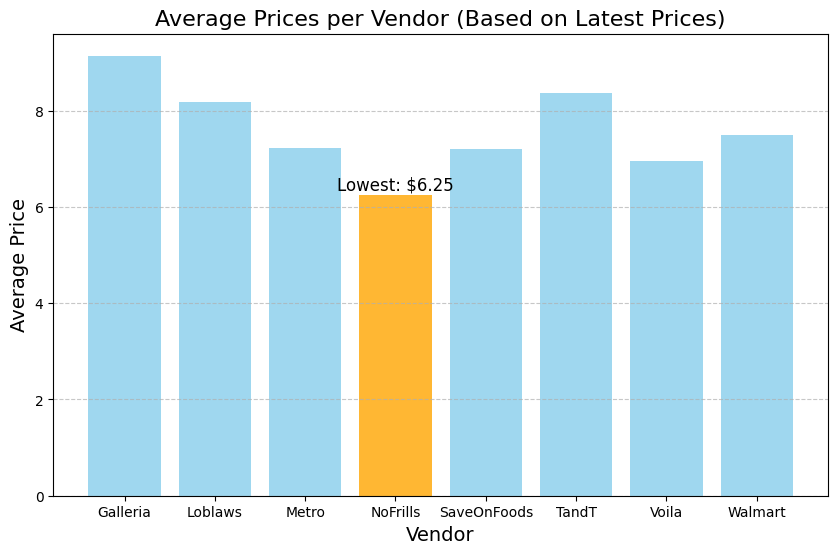

In [20]:
plt.figure(figsize=(10, 6))

average_prices_df = average_prices_per_vendor.reset_index()
average_prices_df.columns = ['Vendor', 'Average Price']
min_index = average_prices_df['Average Price'].idxmin()

colors = ['skyblue'] * len(average_prices_df)
colors[min_index] = 'orange'  # Highlight the lowest price

plt.bar(average_prices_df['Vendor'], average_prices_df['Average Price'], color=colors, alpha=0.8)

lowest_price_vendor = average_prices_df.loc[min_index, 'Vendor']
lowest_price_value = average_prices_df.loc[min_index, 'Average Price']
plt.text(
    min_index, 
    lowest_price_value + 0.1,
    f"Lowest: ${lowest_price_value:.2f}",
    color='black', 
    ha='center', 
    fontsize=12
)

plt.title('Average Prices per Vendor (Based on Latest Prices)', fontsize=16)
plt.xlabel('Vendor', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
df['current_price'] = pd.to_numeric(df['current_price'], errors='coerce')
df = df.dropna(subset=['current_price'])  # Drop rows with missing prices

df['year'] = df['nowtime'].dt.year

vendor_trends = df.groupby(['year', 'vendor'])['current_price'].mean().reset_index()

print("Vendor Trends DataFrame:")
print(vendor_trends)

Vendor Trends DataFrame:
   year       vendor  current_price
0  2024     Galleria       8.979362
1  2024      Loblaws       8.012958
2  2024        Metro       7.244627
3  2024     NoFrills       6.125541
4  2024  SaveOnFoods       7.122688
5  2024        TandT       7.711358
6  2024        Voila       6.969025
7  2024      Walmart       5.888342


In [22]:
vendor_trends['is_lowest'] = vendor_trends.groupby('year')['current_price'].transform(lambda x: x == x.min())

lowest_price_counts = vendor_trends[vendor_trends['is_lowest']].groupby('vendor').size()

print("\nNumber of years each vendor had the lowest average price:")
print(lowest_price_counts)


Number of years each vendor had the lowest average price:
vendor
Walmart    1
dtype: int64


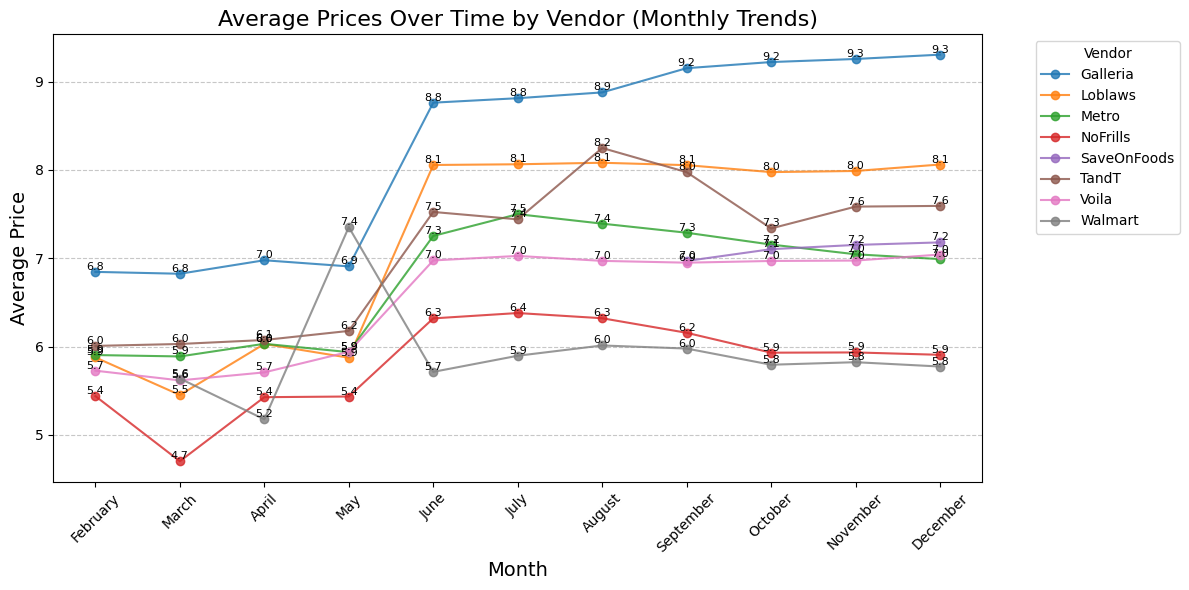

In [23]:
df['month'] = df['nowtime'].dt.to_period('M')

vendor_monthly_trends = df.groupby(['month', 'vendor'])['current_price'].mean().reset_index()

pivot = vendor_monthly_trends.pivot(index='month', columns='vendor', values='current_price')

threshold = 50
pivot[pivot > threshold] = None

plt.figure(figsize=(12, 6))
for vendor in pivot.columns:
    plt.plot(
        pivot.index.astype(str), 
        pivot[vendor], 
        marker='o', 
        label=vendor, 
        alpha=0.8
    )

plt.title('Average Prices Over Time by Vendor (Monthly Trends)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.legend(title='Vendor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

month_labels = [period.strftime('%B') for period in pivot.index]
plt.xticks(ticks=range(len(month_labels)), labels=month_labels, rotation=45)

plt.tight_layout()

for vendor in pivot.columns:
    for x, y in enumerate(pivot[vendor]):
        if not pd.isna(y):
            plt.text(x, y, f"{y:.1f}", fontsize=8, ha='center', va='bottom')

plt.show()

In [24]:
trend_analysis = {}
for vendor in pivot.columns:
    x = range(len(pivot.index))
    y = pivot[vendor].dropna()
    
    if len(y) > 1: 
        slope, intercept, r_value, p_value, std_err = linregress(x[:len(y)], y)
        trend_analysis[vendor] = slope

# Sort vendors by their trend slope
trend_analysis = pd.Series(trend_analysis).sort_values()

print("\nTrend Slopes (Negative is better for downward trend):")
print(trend_analysis)

best_downward_trend_vendor = trend_analysis.idxmin()
print(f"\nThe vendor with the best downward trend is: {best_downward_trend_vendor}")


Trend Slopes (Negative is better for downward trend):
Walmart       -0.006861
SaveOnFoods    0.067930
NoFrills       0.092919
Metro          0.147924
Voila          0.161824
TandT          0.202327
Loblaws        0.284437
Galleria       0.303278
dtype: float64

The vendor with the best downward trend is: Walmart
